In [115]:
import sys
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib 
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, \
    BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint 
from matplotlib import pyplot
from tensorflow.python.framework import ops
import matplotlib.cm as cm
import random

In [116]:
WEIGHTS_FOLDER = 'weights/'
if not os.path.exists(WEIGHTS_FOLDER):
#  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

In [117]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
INPUT_DIM = (IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)
BATCH_SIZE = 64
Z_DIM = 100
TRAIN_PATH='train/train'
ANNOT_PATH='train/mask'

In [118]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size,
                      conv_strides, use_batch_norm=False, use_dropout=False):
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu,
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model
    # would be inconsistent
    global K
    K.clear_session()

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape=input_dim, name='encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters=conv_filters[i],
                   kernel_size=conv_kernel_size[i],
                   strides=conv_strides[i],
                   padding='same',
                   name='encoder_conv_' + str(i)
                   )(x)
        if use_batch_norm:
            x = BathcNormalization()(x)

        x = LeakyReLU()(x)

        if use_dropout:
            x = Dropout(rate=0.25)(x)

    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:]

    x = Flatten()(x)

    mean_mu = Dense(output_dim, name='mu')(x)
    log_var = Dense(output_dim, name='log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
        return mean_mu + K.exp(log_var / 2) * epsilon

        # Using a Keras Lambda Layer to include the sampling function as a layer

    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input,
                                                                                           encoder_output)

vae_encoder_input, vae_encoder_output, mean_mu, log_var, vae_shape_before_flattening, vae_encoder = build_vae_encoder(
    input_dim=INPUT_DIM,
    output_dim=Z_DIM,
    conv_filters=[32,64,64,64],
    conv_kernel_size=[3, 3, 3, 3],
    conv_strides=[2, 2, 2, 2])

vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [119]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim=Z_DIM,
                                                                   shape_before_flattening=vae_shape_before_flattening,
                                                                   conv_filters=[64, 64, 32, 1],
                                                                   conv_kernel_size=[ 3, 3, 3, 3],
                                                                   conv_strides=[ 2, 2, 2, 2])
vae_decoder.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0   

In [120]:
import cv2

def data_gen(img_folder, mask_folder, batch_size):
  c = 0
  n = list(int(s.split(".")[0]) for s in list(next(os.walk(img_folder))[2]))
  random.shuffle(n)
  
  while (True):
    img = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)).astype('float')
    mask = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1)).astype('float')

    for i in range(c, c+batch_size): #initially from 0 to 16, c = 0. 
      #print(i)
      train_img = cv2.imread(img_folder+'/'+str(n[i])+'.jpg')/255.
      train_img =  cv2.resize(train_img, (IMG_HEIGHT, IMG_WIDTH))# Read an image from folder and resize
      
      img[i-c] = train_img #add to array - img[0], img[1], and so on.
                                                   
      
      train_mask = cv2.imread(mask_folder+'/'+str(n[i])+'.png', cv2.IMREAD_GRAYSCALE)/255.
      train_mask = cv2.resize(train_mask, (IMG_HEIGHT, IMG_WIDTH))
      train_mask = train_mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]

      mask[i-c] = train_mask

    c+=batch_size
    if(c+batch_size>=len(os.listdir(img_folder))):
      c=0
      random.shuffle(n)
      random.shuffle(m)
      
                  # print "randomizing again"
    yield img, mask




train_frame_path = 'train/train'
train_mask_path = 'train/mask'

val_frame_path = 'Dataset/images/train images'
val_mask_path = 'Dataset/masks/train label'

# Train the model
train_gen = data_gen(train_frame_path,train_mask_path, batch_size = BATCH_SIZE)
val_gen = data_gen(val_frame_path,val_mask_path, batch_size = BATCH_SIZE)

In [121]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    train_ids = list(int(s.split(".")[0]) for s in list(next(os.walk(path))[2]))
    image = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        img = imread(path+'/'+str(id_)+'.jpg')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        image[n] = img.astype('uint8') / 255
    return image

In [122]:
'''def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g=tf.compat.v1.get_default_graph()     
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
        new_model.summary()
    return new_model'''

'def build_guided_model():\n    """Function returning modified model.\n    \n    Changes gradient function for all ReLu activations\n    according to Guided Backpropagation.\n    """\n    if "GuidedBackProp" not in ops._gradient_registry._registry:\n        @ops.RegisterGradient("GuidedBackProp")\n        def _GuidedBackProp(op, grad):\n            dtype = op.inputs[0].dtype\n            return grad * tf.cast(grad > 0., dtype) *                    tf.cast(op.inputs[0] > 0., dtype)\n\n    g=tf.compat.v1.get_default_graph()     \n    with g.gradient_override_map({\'Relu\': \'GuidedBackProp\'}):\n        new_model = build_model()\n        new_model.summary()\n    return new_model'

In [123]:
def build_model():
    vae_input = vae_encoder_input
    vae_output = vae_decoder(vae_encoder_output)
    vae_model = Model(vae_input, vae_output)
    
    return vae_model

In [124]:
'''from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

%env SM_FRAMEWORK=tf.keras

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis=1)
    return kl_loss


def total_loss(y_true, y_pred):
    return LOSS_FACTOR * r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)



adam_optimizer = Adam(lr=LEARNING_RATE)
model = build_model()
model.compile('Adam', loss=total_loss, metrics=[r_loss, kl_loss])

#model.summary()
#model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/model_praveen.hdf5'), save_weights_only = True, verbose=1)
'''

"from segmentation_models.losses import bce_jaccard_loss\nfrom segmentation_models.metrics import iou_score\nfrom tensorflow.keras.optimizers import Adam\nLEARNING_RATE = 0.0005\nN_EPOCHS = 200\nLOSS_FACTOR = 10000\n\n%env SM_FRAMEWORK=tf.keras\n\ndef r_loss(y_true, y_pred):\n    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])\n\ndef kl_loss(y_true, y_pred):\n    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis=1)\n    return kl_loss\n\n\ndef total_loss(y_true, y_pred):\n    return LOSS_FACTOR * r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)\n\n\n\nadam_optimizer = Adam(lr=LEARNING_RATE)\nmodel = build_model()\nmodel.compile('Adam', loss=total_loss, metrics=[r_loss, kl_loss])\n\n#model.summary()\n#model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])\ncheckpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/model_praveen.hdf5'), save_weights_only = True, verbose=1)\n"

In [125]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

%env SM_FRAMEWORK=tf.keras
"""
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis=1)
    return kl_loss


def total_loss(y_true, y_pred):
    return LOSS_FACTOR * r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
"""


#adam_optimizer = Adam(lr=LEARNING_RATE)
"""model = build_model()
#model.compile(optimizer=adam_optimizer, loss=total_loss, metrics=[r_loss, kl_loss])

model.summary()
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/model_praveen.hdf5'), save_weights_only = True, verbose=1)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-125-541b8e420d29>, line 29)

In [126]:
model = build_model()
model.summary()
model.load_weights('SegGradCAM.hdf5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [127]:
NO_OF_TRAINING_IMAGES = len(os.listdir(train_frame_path))
NO_OF_VAL_IMAGES = len(os.listdir(val_frame_path))

In [128]:
"""model.fit(train_gen, epochs=5,
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_gen, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE),
                          #callbacks=callbacks_list,
                          callbacks=[checkpoint_vae])

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-128-4a2f0296d87e>, line 6)

In [129]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, encoder_out, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.get_layer(encoder_out).output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        #preds = preds.squeeze()
        #class_channel = preds[2][0][0]
    #print("shape of class_channel: "+str(tf.shape(class_channel)))
    #print("class_channel: "+str((class_channel)))
    #print("last_conv_layer_output: "+str(last_conv_layer_output))
    
    grads = tape.gradient(preds, last_conv_layer_output)
    
    """with tf.GradientTape() as tape_1:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[2])
        class_channel = preds[2][0][1]
    grads_1 = tape_1.gradient(class_channel, last_conv_layer_output)"""

    #print("grads: "+str((grads)))
    #print("###############grads_1: "+str((grads_1)))
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #pooled_grads_1 = tf.reduce_mean(grads_1, axis=(0, 1, 2))
    #print("pooled_grads: "+str(tf.shape(pooled_grads)))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    #heatmap_1 = last_conv_layer_output @ pooled_grads_1[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    #heatmap_1 = tf.squeeze(heatmap_1)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    #heatmap_1 = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap_1)
    #print("heatmap: "+str((heatmap)))
    return heatmap.numpy()

In [217]:
last_conv_layer_name = "encoder_conv_3"
encoder_out = "encoder_output"

In [256]:
img_path='Dataset/image'
a = load_image(img_path)



100%|██████████| 8/8 [00:00<00:00, 81.71it/s]


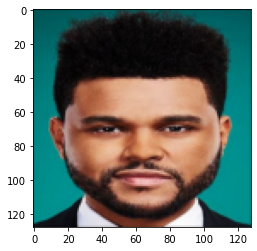

In [258]:
matplotlib.pyplot.imshow(a[1])

In [272]:
img_array = a[1]
img_array = keras.preprocessing.image.img_to_array(img_array)
img_array = np.expand_dims(img_array, axis=0)


In [273]:
res = model.predict(img_array)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, encoder_out)

In [274]:
res = res.squeeze()

In [275]:
res.shape

(128, 128)

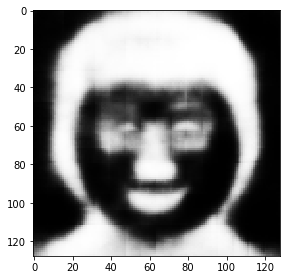

In [276]:
imshow(res)

In [277]:
#res = res.squeeze()
#res=tf.make_ndarray(res)
#print(res.size)

from PIL import Image
res = res*255
res = res.astype(np.uint8)
res = Image.fromarray(res)

#imshow(res)
res.save("VAE_generated_image.jpeg")

(1, 128, 128, 3)


True

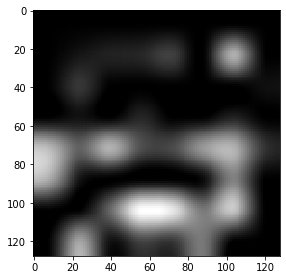

In [278]:
hm = np.uint8(255 * heatmap)
hm = np.expand_dims(hm, axis=2)
hm = keras.preprocessing.image.array_to_img(hm)
print(img_array.shape)
hm = hm.resize((img_array.shape[1], img_array.shape[2]))
hm = np.asanyarray(hm)
imshow(hm)
#hm.save("heatmap.jpg")
cv2.imwrite('hm.jpeg', hm)

In [279]:
def save_and_display_gradcam(img, heatmap,cam_path="superimposed_img.jpg", alpha=0.4):
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    #heatmap_1 = np.uint8(255 * heatmap_1)
    #hmap = hmap.resize((img.shape[1], img.shape[0]))
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    print(jet_heatmap.shape)
    print(img.shape)
    superimposed_img = cv2.addWeighted(jet_heatmap, 0.005, img, 0.995, 0)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    

In [280]:
save_and_display_gradcam(img_array.squeeze(), heatmap)

(128, 128, 3)
(128, 128, 3)


In [281]:
heatmap_images = 'opop'

In [282]:
def save_individual_heatmaps_1(img_array, model, last_conv_layer_name, encoder_out, pred_index=None):
  grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.get_layer(encoder_out).output]
    )
  no_of_channels = (model.get_layer(encoder_out).output.get_shape())[1]
  for i in range(no_of_channels):
    with tf.GradientTape(persistent=True) as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      y = preds[0][i]
      if(i==1909):
        y = tf.math.multiply(y,tf.constant(1000, dtype=tf.float32))
    grads = tape.gradient(y, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.matmul(last_conv_layer_output, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    #if(i==199):
      #print("heatmap: "+str(heatmap))
      #print("mean: "+str(tf.math.reduce_mean(heatmap)))
    #save_and_display_gradcam(img_array.squeeze(), heatmap)
    save_and_display_gradcam(img_array.squeeze(), heatmap, cam_path=heatmap_images+"/heatmap_"+str(i)+".jpg")

In [283]:
save_individual_heatmaps_1(img_array, model, last_conv_layer_name, encoder_out)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 